# PER DQN
PER DQN 的核心思想是很简单的, 就是把普通的经验回放改成了优先级经验回放, 但是实现上却没那么简单.
1. 先实现 SumTree 这个数据结构, 用于存储优先级和索引.
2. 实现一个经验回放的类, 用于存储经验, 采样经验, 更新优先级.

# 伪代码

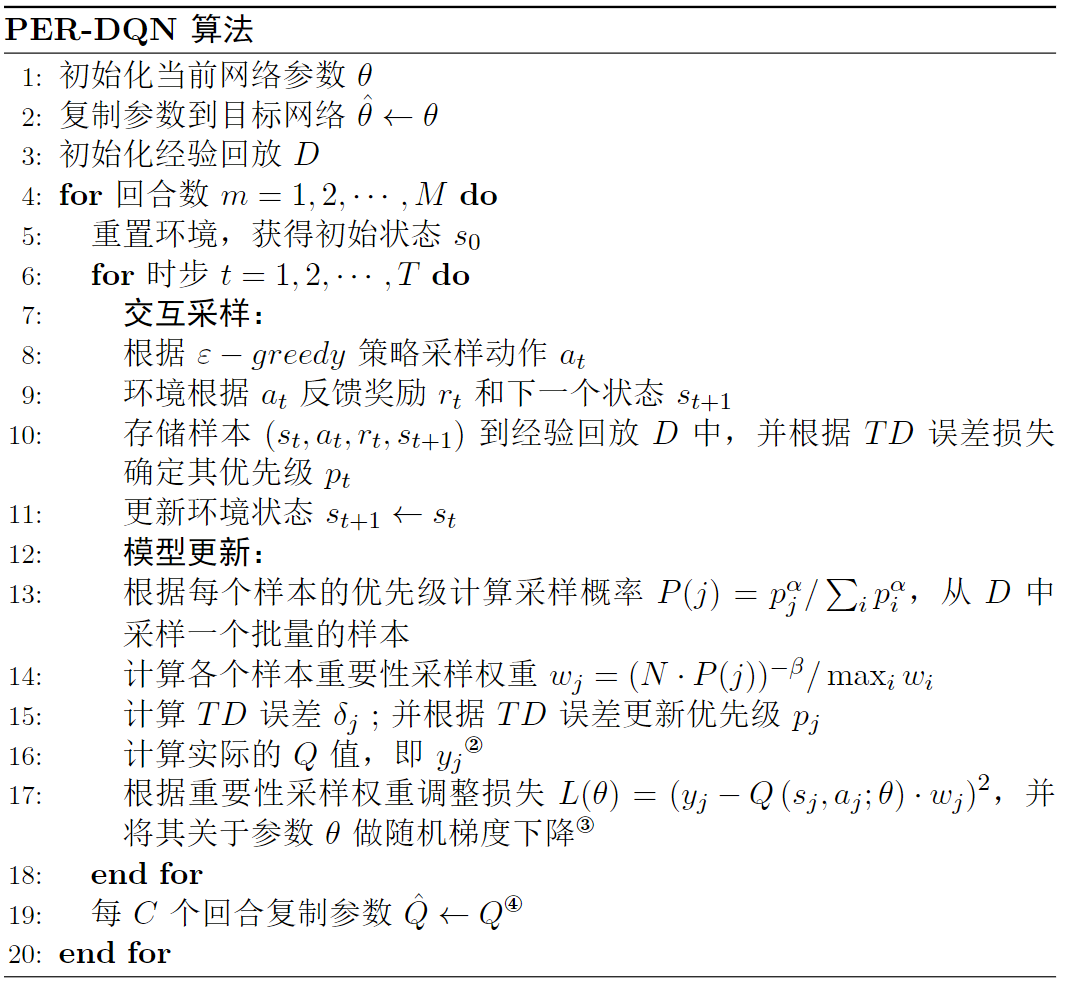

## SumTree
SumTree样式

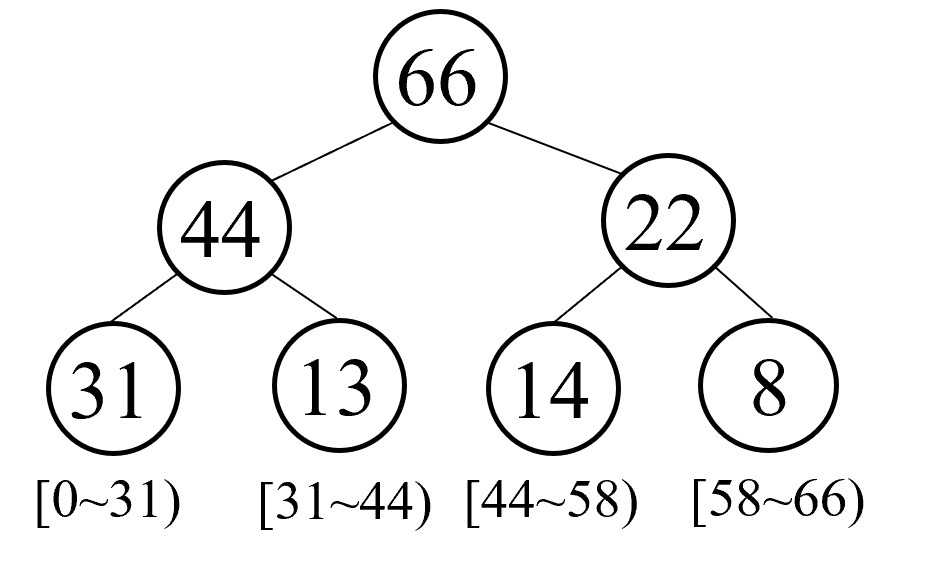

In [ ]:
# SumTree 

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)          # 注: 用数组表示的 "完全二叉树"
        self.data = np.zeros(capacity, dtype=object)    # 存储叶子节点的样本
        self.write_idx = 0                              # 写入样本的索引
        self.count = 0                                  # 当前存储的样本数量
    
    def add(self, priority, exps):
        ''' 
        添加一个样本到叶子节点，并更新其父节点的优先级
        '''
        idx = self.write_idx + self.capacity - 1        # 样本的索引  (idx 是 叶子节点在 Tree 中的位置)
        self.data[self.write_idx] = exps                # 写入样本 (注意data里都是叶子节点)
        self.update(idx, priority)                      # 更新样本的优先级
        self.write_idx = (self.write_idx + 1) % self.capacity # 更新写入样本的索引
        if self.count < self.capacity:
            self.count += 1
    
    def update(self, idx, priority):
        ''' 
        更新叶子节点的优先级，并更新其父节点的优先级
        Args:
            idx (int): 样本的索引
            priority (float): 样本的优先级
        '''
        diff = priority - self.tree[idx] # 优先级的差值
        
        # 更新叶子节点的优先级
        self.tree[idx] = priority
        
        # 遍历更新父节点的优先级
        while idx != 0: 
            idx = (idx - 1) // 2
            self.tree[idx] += diff
    
    def get_leaf(self, v):
        ''' 
        根据优先级的值采样对应区间的叶子节点样本
        Input:
            v:              用于选择一个叶子节点 (通常是随机数)
        Output:
            idx:            选择的叶子节点的索引
            tree[index]:    选择的叶子节点的优先级
            data:           选择的叶子节点的样本
        '''
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            
            # 比较v与左右节点的优先级, 用于选择左右节点
            if v <= self.tree[left]:
                idx = left
            else:
                v -= self.tree[left]
                idx = right
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]
    
    def get_data(self, indices):
        """ 
        根据索引获取对应的样本.
        """
        return [self.data[idx - self.capacity + 1] for idx in indices]
    
    def total(self):
        ''' 
        返回所有样本的优先级之和，即根节点的值
        '''
        return self.tree[0]
    
    def max_prior(self):
        ''' 
        返回所有样本的最大优先级
        '''
        return np.max(self.tree[(self.capacity-1) : (self.capacity + self.write_idx-1)])


In [ ]:
# 优先级经验回放 -- 基于 SumTree 实现
""" 
实现了 O(logN) 时间复杂度内的 添加, 更新 和 采样操作.

实际中:
- 经验回放容量一般设置为 10^6
- alpha 一般设置为 0.6
- beta 一般设置为 0.4
- beta_annealing (beta_step) 一般设置为 0.0001
- epsilon 一般设置为 0.01
"""

class PrioritizedReplayBuffer:
    def __init__(self, cfg):
        self.capacity = cfg.buffer_size
        self.alpha = cfg.per_alpha                   # 优先级的指数参数，越大越重要，越小越不重要
        self.epsilon = cfg.per_epsilon               # 优先级的最小值，防止优先级为0
        self.beta = cfg.per_beta                     # importance sampling 的参数
        self.beta_annealing = cfg.per_beta_annealing # beta 的增长率 (annealing: 退火)
        self.tree = SumTree(self.capacity)           # sumtree 对象, 存储样本, 管理优先级
        self.max_priority = 1.0                      # 初始的最大优先级, 用于新加入的样本
    
    def push(self, exps):
        ''' 
        添加样本
            新样本加入时，其优先级设置为当前树中的最大优先级，确保新样本有较高的被采样概率.
        '''
        priority = self.max_priority if self.tree.total() == 0 else self.tree.max_prior()
        self.tree.add(priority, exps)
    
    def sample(self, batch_size):
        ''' 
        采样一个批量样本
        '''
        indices = []        # 被选中样本的索引
        priorities = []     # 选中的样本对应的优先级
        exps = []           # 被选中的样本数据
        segment = self.tree.total() / batch_size        # 通过均匀分割总优先级范围来选择样本，确保每个样本被选中的概率与其优先级相关
        self.beta = min(1.0, self.beta  + self.beta_annealing)
        for i in range(batch_size):                     # 采样 batch_size 个样本
            a = segment * i
            b = segment * (i + 1)
            p = np.random.uniform(a, b)                 # 采样一个优先级
            idx, priority, exp = self.tree.get_leaf(p)  # 采样一个样本
            indices.append(idx)
            priorities.append(priority)
            exps.append(exp)
        
        # 重要性采样, weight = (N * P(i)) ^ (-beta) / max_weight
        sample_probs = np.array(priorities) / self.tree.total()    # 每个样本被选中的概率, P(i)
        weights = (self.tree.count * sample_probs) ** (-self.beta) # importance sampling的权重
        weights /= weights.max() # 归一化
        indices = np.array(indices)
        return zip(*exps), indices, weights
    
    def update_priorities(self, indices, priorities):
        ''' 
        更新样本的优先级
            epsilon 确保优先级不为零, alpha 调整优先级的影响力。
        '''
        priorities = np.abs(priorities) # 取绝对值
        for idx, priority in zip(indices, priorities):
            # 控制衰减的速度, priority = (priority + epsilon) ^ alpha
            priority = (priority + self.epsilon) ** self.alpha
            priority = np.minimum(priority, self.max_priority)
            self.tree.update(idx, priority)
    
    def __len__(self):
        return self.tree.count


In [ ]:
# 优先级经验回放 -- 基于队列实现
""" 
相比基于 SumTree 的实现方式:
- 用队列使代码更简洁
- 在采样的时候不需要 for-loop
"""

import numpy as np
from collections import deque

class PrioritizedReplayBufferQue:
    def __init__(self, cfg):
        self.capacity = cfg.buffer_size
        self.alpha = cfg.per_alpha                    # 优先级的指数参数，越大越重要，越小越不重要
        self.epsilon = cfg.per_epsilon                # 优先级的最小值，防止优先级为0
        self.beta = cfg.per_beta                      # importance sampling的参数
        self.beta_annealing = cfg.per_beta_annealing  # beta的增长率
        self.buffer = deque(maxlen=self.capacity)     # 使用双端队列存储样本
        self.priorities = deque(maxlen=self.capacity) # 使用双端队列存储样本的优先级
        self.count = 0                                # 当前存储的样本数量
        self.max_priority = 1.0
    
    def push(self,exps):
        self.buffer.append(exps)
        self.priorities.append(max(self.priorities, default=self.max_priority)) # 设置新样本的优先级为当前最大优先级。
        self.count += 1
    
    def sample(self, batch_size):
        priorities = np.array(self.priorities)                              # 将优先级列表转换为数组
        probs = priorities/sum(priorities)                                  # 计算每个样本被选中的概率
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)   # 采样 batch_size 个样本
        weights = (self.count*probs[indices])**(-self.beta)                 # importance sampling的权重
        weights /= weights.max()
        exps = [self.buffer[i] for i in indices]                            # 获取选中的样本
        return zip(*exps), indices, weights
    
    def update_priorities(self, indices, priorities):
        priorities = np.abs(priorities)                                      # 取优先级的绝对值。
        priorities = (priorities + self.epsilon) ** self.alpha               # 控制衰减的速度
        priorities = np.minimum(priorities, self.max_priority).flatten()     # 限制优先级的最大值
        
        # 更新对应样本的优先级。
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
    
    def __len__(self):
        return self.count
